# 20 Newsgroups

In [26]:
from src.model_utils import *
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.pipeline import Pipeline

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

## EDA

### Data loading

Let's get the raw texts and strip newsgroup-related metadata such as headers, signature blocks and quotation blocks to prevent overfitting afterwards.

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

### Data quality checks

Let's see what are unique categories of our text data.

In [3]:
categories = list(newsgroups_train.target_names)
print(f'We have {len(categories)} unique categories:\n\n{chr(10).join(categories)}')

We have 20 unique categories:

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


Some of the newsgroups are very closely related to each other (like ***comp.sys.ibm.pc.hardware*** / ***comp.sys.mac.hardware***, ***rec.sport.baseball*** / ***rec.sport.hockey***), while others are highly unrelated.

In [4]:
print(f'Filenames shape is {newsgroups_train.filenames.shape}\nTarget shape is {newsgroups_train.target.shape} ')

Filenames shape is (11314,)
Target shape is (11314,) 


### Insights about target

Let's see what our target looks like and whether we have the balanced data.

In [5]:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

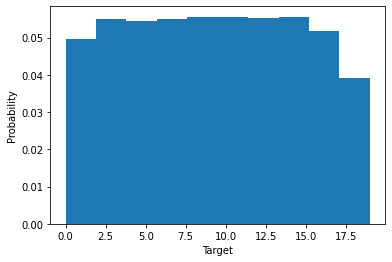

In [6]:
plt.hist(newsgroups_train.target, density=True)
plt.xlabel('Target')
plt.ylabel('Probability')
plt.show()

From the histogram above we conclude that we deal with balanced data so one of our evaluation metrics would be accuracy.

## Text preprocessing. Modeling

So far we have raw text data and we need to extract features for our future models - we'll turn the text into vectors of numerical values. <br> 
We'll start with the basic text preprocessing approach - **bag-of-words**. We'll use **tf-idf** as preprocessing step and **multinomual naive bayes model** as an estimator. 

### TF-IDF & MultinomialNB

In [7]:
X_train, y_train = newsgroups_train.data, newsgroups_train.target
X_test, y_test = newsgroups_test.data, newsgroups_test.target

In [8]:
pipe = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [9]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

f1 score = 0.5854345727938506
accuracy = 0.6062134891131173


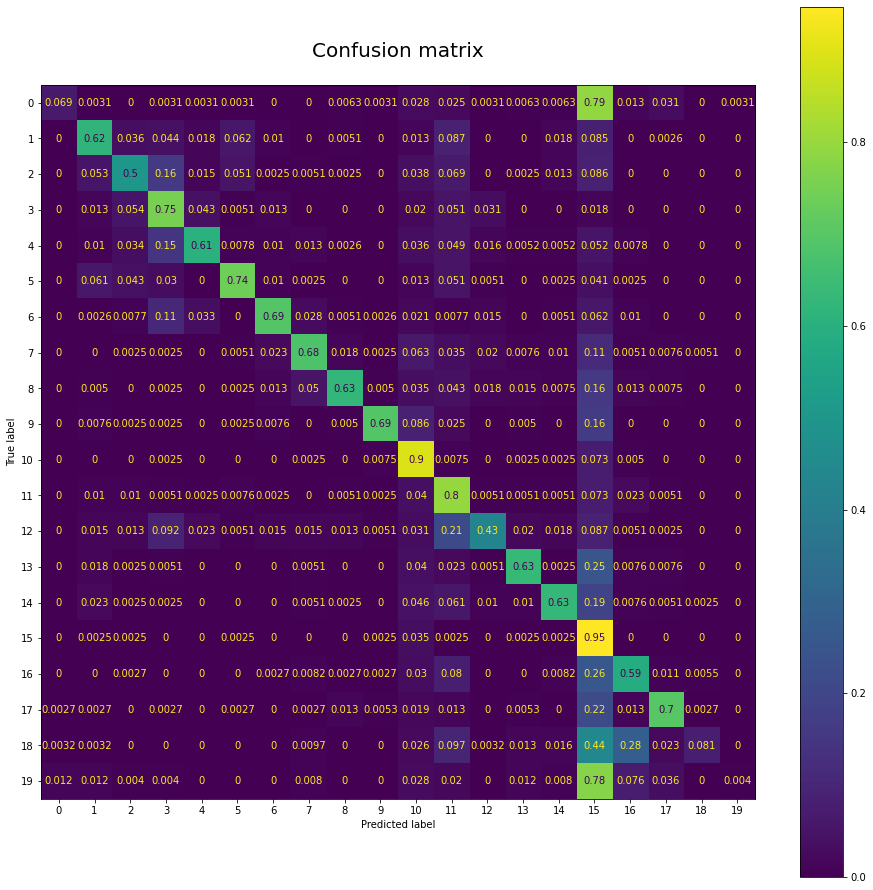

In [10]:
f1, acc = evaluate(y_test, y_pred)
print(f'f1 score = {f1}\naccuracy = {acc}')

In [11]:
def objective(trial):
    
#     classifier_name = trial.suggest_categorical('classifier', ['mnb', 'lsvc'])
    
#     if classifier_name == 'mnb':
    
    param = {
        'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
        'mnb__alpha': trial.suggest_float('mnb__alpha', 1e-8, 1.0, log=True)
    }
        
    model = pipe.set_params(**param)
    
#     else: 
#         param = {
#             'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
#             'lsvc__C': trial.suggest_int('lsvc__C', 1, 151, 50)
            
#         }
        
#         model = pipe_lsvc.set_params(**param)
    
   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = evaluate(y_test, y_pred, print_cm=False)
    
    return acc

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [13]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.701805629314923
  Params: 
    tf-idf__max_df: 0.23983844140176203
    mnb__alpha: 0.03237688403996004


In [14]:
pipe.set_params(**pipe_params)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [15]:
f1, acc = evaluate(y_test, y_pred, print_cm=False)
print(f'f1 score = {f1}\naccuracy = {acc}')

f1 score = 0.6799305834350592
accuracy = 0.701805629314923


### TF-IDF & LinearSVC

In [17]:
pipe_lsvc = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('lsvc', LinearSVC())
])

In [18]:
pipe_lsvc.fit(X_train, y_train)
y_pred_lsvc = pipe_lsvc.predict(X_test)

f1 score = 0.6810391634643981
accuracy = 0.6919808815719597


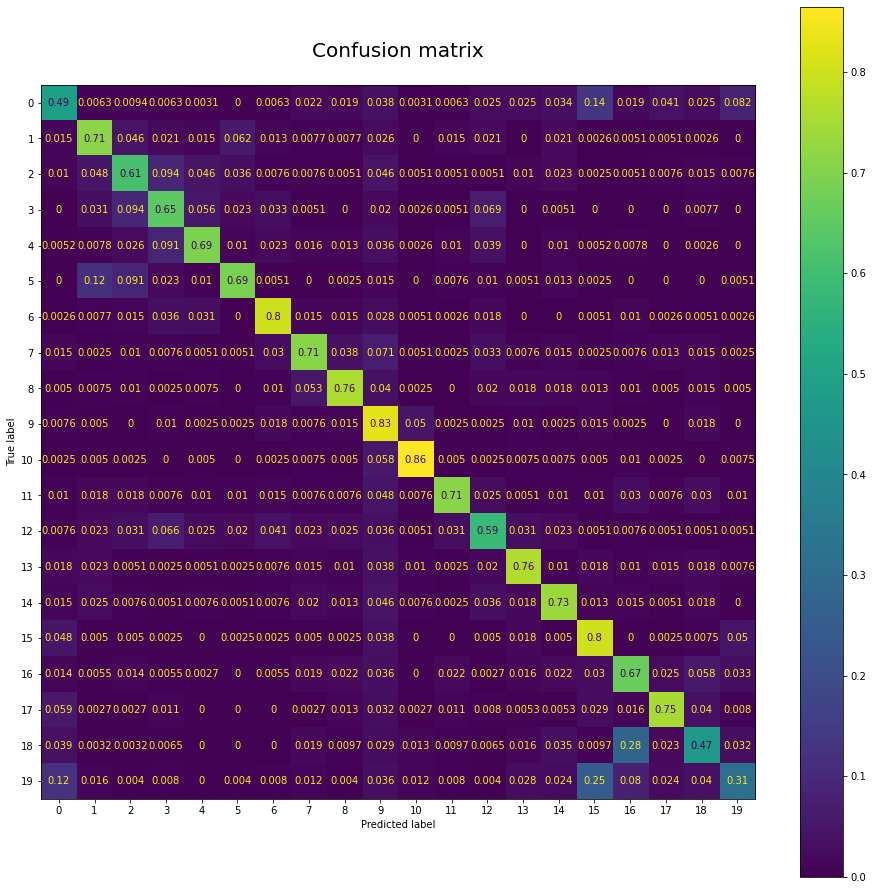

In [20]:
f1, acc = evaluate(y_test, y_pred_lsvc)
print(f'f1 score = {f1}\naccuracy = {acc}')

In [21]:
def objective(trial):
    
    param = {
        'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
        'lsvc__C': trial.suggest_float('lsvc__C', 0.1, 10.0)
            
    }
        
    model = pipe_lsvc.set_params(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = evaluate(y_test, y_pred, print_cm=False)
    
    return acc

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [23]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_lsvc_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_lsvc_params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.700477960701009
  Params: 
    tf-idf__max_df: 0.8654997621958702
    lsvc__C: 0.2943849523596078


In [24]:
pipe_lsvc.set_params(**pipe_lsvc_params)
pipe_lsvc.fit(X_train, y_train)
y_pred = pipe_lsvc.predict(X_test)

In [25]:
f1, acc = evaluate(y_test, y_pred, print_cm=False)
print(f'f1 score = {f1}\naccuracy = {acc}')

f1 score = 0.6867356643543703
accuracy = 0.700477960701009


### Voting Classifier

In [31]:
nb = MultinomialNB(alpha=pipe_params['mnb__alpha'])
svc = LinearSVC(C=pipe_lsvc_params['lsvc__C'])

voting_clf = VotingClassifier(
estimators=[('mnb', nb), ('lsvc', svc)])

In [32]:
pipe_vote = Pipeline([
    ('tf-idf', TfidfVectorizer(max_df=pipe_params['tf-idf__max_df'])),
    ('voting_clf', voting_clf)
])

In [33]:
pipe_vote.fit(X_train, y_train)
y_pred_vote = pipe_vote.predict(X_test)

In [34]:
f1, acc = evaluate(y_test, y_pred_vote, print_cm=False)
print(f'f1 score = {f1}\naccuracy = {acc}')

f1 score = 0.6747691825674919
accuracy = 0.6980881571959638


In [37]:
def objective(trial):
    
    param = {
        'tf-idf__max_df': trial.suggest_float('tf-idf__max_df', 0.1, 1.0),
        'voting_clf__mnb__alpha': trial.suggest_float('mnb__alpha', 1e-8, 1.0, log=True),
        'voting_clf__lsvc__C': trial.suggest_float('lsvc__C', 0.1, 10.0)
            
    }
        
    model = pipe_vote.set_params(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = evaluate(y_test, y_pred, print_cm=False)
    
    return acc

In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [39]:
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
pipe_vote_params = trial.params

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in pipe_vote_params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.700477960701009
  Params: 
    tf-idf__max_df: 0.10568492693077586
    mnb__alpha: 0.013402610436486339
    lsvc__C: 0.4022869767383519


In [41]:
nb = MultinomialNB(alpha=pipe_vote_params['mnb__alpha'])
svc = LinearSVC(C=pipe_vote_params['lsvc__C'])

voting_clf = VotingClassifier(
estimators=[('mnb', nb), ('lsvc', svc)])

pipe_vote = Pipeline([
    ('tf-idf', TfidfVectorizer(max_df=pipe_vote_params['tf-idf__max_df'])),
    ('voting_clf', voting_clf)
])

pipe_vote.fit(X_train, y_train)
y_pred = pipe_vote.predict(X_test)

In [42]:
f1, acc = evaluate(y_test, y_pred, print_cm=False)
print(f'f1 score = {f1}\naccuracy = {acc}')

f1 score = 0.6821311269437387
accuracy = 0.700477960701009
